Install libraries

In [2]:
!pip install nltk
!pip install datasets
!pip install transformers==4.36.2 accelerate==0.25.0
!pip install tokenizers
!pip install evaluate
!pip install sentencepiece
!pip install huggingface_hub
!pip install peft==0.8.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.12.0
    Uninstalling accelerate-1.12.0:
      Successfully uninstalled accelerate-1.12.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

Import libraries


In [3]:
import datasets
import nltk
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Load the tokenizer, model  and data collator

In [4]:
Model_name = 'google/flan-t5-small'

tokenizer = T5Tokenizer.from_pretrained(Model_name)
model = T5ForConditionalGeneration.from_pretrained(Model_name)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer , model=model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Get the dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="helpdesk_dataset.json")


Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
#split into training and testing datasets
dataset = dataset['train'].train_test_split(test_size=0.2)

#total number of observations in both training and testing data
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'response'],
        num_rows: 400
    })
    test: Dataset({
        features: ['instruction', 'response'],
        num_rows: 100
    })
})

Data formatting and tokenization

In [12]:
#prefix tasks with "answer the question"
prefix = "Answer the question"

#Preprocessing function
def preprocess (examples):
  "Add prefix to the sentences , tokenize the text and set the labels"
  # The "inputs" are the tokenized answer:
  inputs = [prefix + doc for doc in examples["instruction"]]
  model_inputs = tokenizer(inputs, max_length=128, truncation=True)

  # The "labels" are the tokenized outputs:
  labels = tokenizer(text_target=examples["response"],
                      max_length=512,
                      truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [13]:
# Map the preprocessing function across dataset
tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
lora_config = LoraConfig(
    r=88,
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)


In [10]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,784,704 || all params: 80,745,856 || trainable%: 4.687180478958574


In [24]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-4,  # A common learning rate for LoRa
    save_steps=50
)

print(training_args)

Seq2SeqTrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
generation_config=None,
generation_max_length=None,
generation_num_beams=None,
gradient_accumulation_steps=1

In [25]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
print("Seq2SeqTrainer initialized successfully with updated training arguments.")

Seq2SeqTrainer initialized successfully with updated training arguments.


In [26]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,2.558800
20,2.732900
30,2.658700
40,2.597900
50,2.552300
60,2.582600
70,2.382700
80,2.465100
90,2.423700
100,2.456500


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=150, training_loss=2.465093790690104, metrics={'train_runtime': 417.8517, 'train_samples_per_second': 2.872, 'train_steps_per_second': 0.359, 'total_flos': 7084170952704.0, 'train_loss': 2.465093790690104, 'epoch': 3.0})

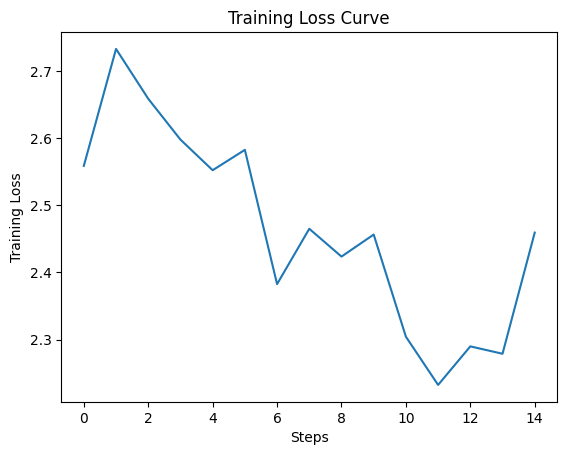

In [39]:
#Training Loss Curve

import matplotlib.pyplot as plt

losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()


In [30]:
test_prompts = [
    "How can I reset my student portal password?",
    "Where can I find the exam timetable?",
    "How do I apply for hostel accommodation?",
    "Who should I contact for LMS technical issues?",
    "How can I request an academic transcript?",
    "What should I do if I miss an exam?",
    "How do I access campus Wi-Fi?",
    "How can I contact the university IT helpdesk?",
    "How do I apply for a leave of absence?",
    "Where can I find the academic calendar?"
]


In [41]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

base_model_name = "google/flan-t5-small"

tokenizer = T5Tokenizer.from_pretrained(base_model_name)
base_model = T5ForConditionalGeneration.from_pretrained(base_model_name)

def generate_response(model, prompt):
    input_text = f"Instruction: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt")

    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=False
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("BASE MODEL OUTPUTS\n")

for p in test_prompts:
    print(f"Prompt: {p}")
    print("Response:", generate_response(base_model, p))
    print("-" * 60)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


BASE MODEL OUTPUTS

Prompt: How can I reset my student portal password?
Response: Use a syncing app to reset your student portal password.
------------------------------------------------------------
Prompt: Where can I find the exam timetable?
Response: a tv
------------------------------------------------------------
Prompt: How do I apply for hostel accommodation?
Response: Apply for hostel accommodation in the city of Hostel.
------------------------------------------------------------
Prompt: Who should I contact for LMS technical issues?
Response: Isaas
------------------------------------------------------------
Prompt: How can I request an academic transcript?
Response: Request a transcript of an academic report.
------------------------------------------------------------
Prompt: What should I do if I miss an exam?
Response: If I miss an exam, I should go to the doctor's office.
------------------------------------------------------------
Prompt: How do I access campus Wi-Fi?


In [43]:
from peft import PeftModel

fine_tuned_model = trainer.model

# Ensure the model is in evaluation mode
fine_tuned_model.eval()

print("FINE-TUNED MODEL OUTPUTS (from in-memory trainer.model)\n")

for p in test_prompts:
    print(f"Prompt: {p}")
    print("Response:", generate_response(fine_tuned_model, p))
    print("-" * 60)


FINE-TUNED MODEL OUTPUTS (from in-memory trainer.model)

Prompt: How can I reset my student portal password?
Response: Reset passwords are available through the student portal website.
------------------------------------------------------------
Prompt: Where can I find the exam timetable?
Response: Exam timetables are available on the official website.
------------------------------------------------------------
Prompt: How do I apply for hostel accommodation?
Response: Hostel accommodation applications are submitted through the hostel office.
------------------------------------------------------------
Prompt: Who should I contact for LMS technical issues?
Response: LMS technical issues should be addressed to the technical support team.
------------------------------------------------------------
Prompt: How can I request an academic transcript?
Response: Academic transcript requests are submitted through the academic office.
----------------------------------------------------------